## Неоходимые библиотеки

In [2]:
import pandas as pd
import plotly.express as px

import polars as pl

## Формат данных

Набор данных содержит сделующи колонки: 
- played_ratio_pct - процент прослушивания. Авторы указали, что если played_ratio_pct>100, то человек слушал на повторе песню
- track_length_seconds - длина трека
- event_type - тип события
- is_organic - если 1 - человек послушал сам песню, если 0 то из рекомендаций
- uid, item_id - идентификаторы пользователя и трека
- timestamp - время в секундах, фиксируется каждый 5с

### multi_event

In [3]:
data = pd.read_parquet("../data/source/multi_event.parquet", engine="fastparquet")
data.head()

,uid,timestamp,item_id,is_organic,played_ratio_pct,track_length_seconds,event_type
0,100,39420,8326270,0,100.0,170.0,listen
1,100,39420,1441281,0,100.0,105.0,listen
2,100,39625,286361,0,100.0,185.0,listen
3,100,40110,732449,0,100.0,240.0,listen
4,100,40360,3397170,0,46.0,130.0,listen


Всего в данных 300 дней

In [28]:
print("Дней в данных:", (data["timestamp"].max() - data["timestamp"].min())// (60 * 60 * 24))

Дней в данных: 300


В данных отсутствуют пропуски по uid и item_id

In [9]:
data[data["uid"].isna() | data["item_id"].isna()]

,uid,timestamp,item_id,is_organic,played_ratio_pct,track_length_seconds,event_type


### items-meta

Мета-ифнормация о песнях содержит:
- track_length_seconds	- длина трека
- artist_id	- id артиста 
- album_id  - id альбома 

In [14]:
items_meta = pd.read_parquet("../data/source/items_meta.parquet", engine="fastparquet")
items_meta.head()

,item_id,track_length_seconds,artist_id,album_id
0,8326270,170.0,714356.0,1060653.0
1,8326270,170.0,714356.0,1486663.0
2,1441281,105.0,1043457.0,547645.0
3,286361,185.0,94924.0,141751.0
4,732449,240.0,94924.0,1632076.0


### embeddings

Файл с эмбеддингами содержит все эмбединги датасета. В текущем исследовании используется самая маленькая версия - 50М. Поэтому для дальнейше работы будут отобраны только эти эмбединги.

In [40]:
embed_5b = pl.scan_parquet("../data/source/embeddings.parquet")

total_embeddings_rows = embed_5b.select(pl.len()).collect().item()  # Предполагается, что они все уникальные :)
unique_item_ids_50M = data["item_id"].nunique()

ratio = (unique_item_ids_50M / total_embeddings_rows) * 100


print(f"Используемое количество данные в 50M: {round(ratio, 2)}%")

Используемое количество данные в 50M: 12.1%


In [25]:
import time
start = time.time()

unique_item_50M = data["item_id"].unique().tolist()

(
    embed_5b
    .filter(pl.col("item_id").is_in(unique_item_50M))
    .sink_parquet("../data/source/filtered_embeddings.parquet")
)

end = time.time()
duration = end - start

print(f"⏱ Фильтрация и сохранение завершены за {duration:.2f} сек ({duration/60:.2f} мин).")

⏱ Фильтрация и сохранение завершены за 213.82 сек (3.56 мин).


Данные по эмбедингам содержат 
- item_id - идентификатор песни 
- normalized_embed - нормализованные эмбединги 
- embed - исходные эмбединги 

In [26]:
pl.scan_parquet("../data/source/filtered_embeddings.parquet").collect().head()

item_id,embed,normalized_embed
u32,list[f64],list[f64]
26,"[1.795751, -0.417789, … 2.790108]","[0.048594, -0.011306, … 0.075502]"
43,"[-0.058531, -2.4577, … 0.160615]","[-0.002298, -0.09648, … 0.006305]"
50,"[-1.348751, 1.248032, … -1.081478]","[-0.0526, 0.048672, … -0.042177]"
71,"[-3.612609, -2.756305, … -3.278896]","[-0.142153, -0.108458, … -0.129021]"
81,"[-3.10231, -0.390903, … 0.6384]","[-0.135625, -0.017089, … 0.027909]"


## Типы событий (колонка event_type)

Несмотря на то, что в документации описаны типы событий, повторно посмотрим какие есть и в какой количестве

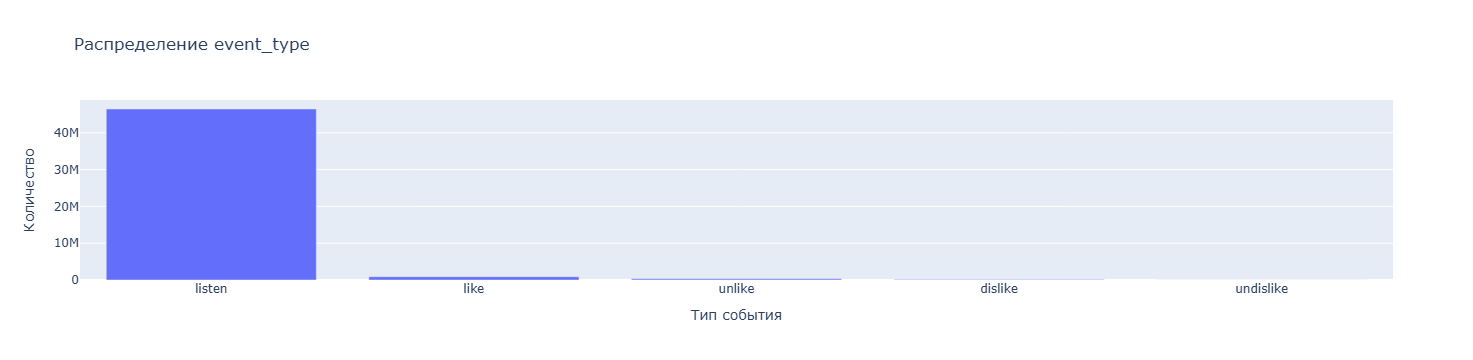

In [30]:
fig = px.bar(
    data["event_type"].value_counts().reset_index(),
    x="index",
    y="event_type",
    labels={"index": "Тип события", "event_type": "Количество"},
    title="Распределение event_type"
)

fig.show()

Можно выделить 2 типа взаимодействия пользователя с аудиодоржной: явные (explicit) - like, unlike, dislike, undislike. Такой тип оценки надержный, он явно показывает понравилась ли песня пользователю или нет.

Другой тип - неявные (implicit) - listen. Таких взаиводейтсвий намного больше, но они не надежные, прослушанная песня еще не признак того, что она понравилась пользователю.

### Listen

Отрисуем только активность прослушивания и окрасим разными цветами разные item_id

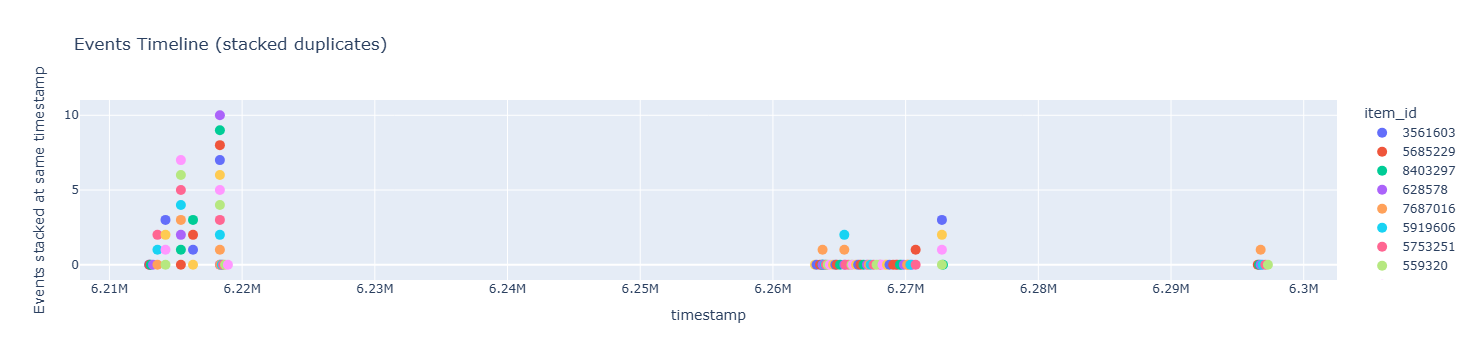

In [4]:
df = data[(data["uid"] == 100) & (data["event_type"] == "listen")].sort_values("timestamp")[900:1000]

df["count_sec"] = df["track_length_seconds"]*df["played_ratio_pct"]*0.01

df["stack_level"] = df.groupby("timestamp").cumcount()

fig = px.scatter(
    df,
    x="timestamp",
    y="stack_level",
    color="item_id",

    hover_data=["event_type", "timestamp", "count_sec"],
    
    title="Events Timeline (stacked duplicates)"
)


fig.update_traces(marker=dict(size=10))
fig.update_yaxes(title="Events stacked at same timestamp", showgrid=True)
fig.show()


Почему в одно время может быть зафиксировано несколько событий
* событие было очень быстрое (пролистывание) и оно поместилось в 1 timestamp
* несколько человек пользуются одним аккаунтом
* ошибка

Для первой итерации такие случаи будут удаляться, потом стоит добавить обработку коротких событий (прослушиваний) 

### like/unlike/dislike/unlike

In [5]:
df_like = data[data["event_type"] != "listen"]

df_like[(df_like["uid"] == 900)&
        (df_like["item_id"] == 3385274)&
        ~(df_like["event_type"] == "listen")][["timestamp", "event_type"]].value_counts()

timestamp  event_type
25457490   unlike        16
           like          16
25457460   like           1
25457470   unlike         1
25457480   like           1
25457485   unlike         1
           like           1
25514485   dislike        1
25514645   like           1
dtype: int64

В данных встречаются ситуации, когда в один и тот же момент времени зафиксировано несколько лайков и дизлайков подряд. Причины могут быть разными: пользователь мог несколько раз нажать на кнопку, произошёл интерфейсный сбой, либо пользователь изменил своё мнение — например, сначала поставил лайк, затем убрал его, а позже снова поставил.

Чтобы корректно обрабатывать такие случаи, для каждой группы событий будем оставлять только последнее зафиксированное действие, определяя его по максимальному индексу строки (поскольку timestamp может быть округлён и не всегда отражает точный порядок событий).

В каждом наборе данных мы обработаем поле event_type, определив итоговую реакцию пользователя. Последовательность событий интерпретируем следующим образом:

- like → like
- unlike → dislike
- dislike → dislike
- undislike → like

Важно выполнять эту логику отдельно для каждой выборки (train, test, val), поскольку мнение пользователя могло измениться после рекомендаций, и агрегировать по всему датасету нельзя.

## Длина трека (колонка track_length_seconds)

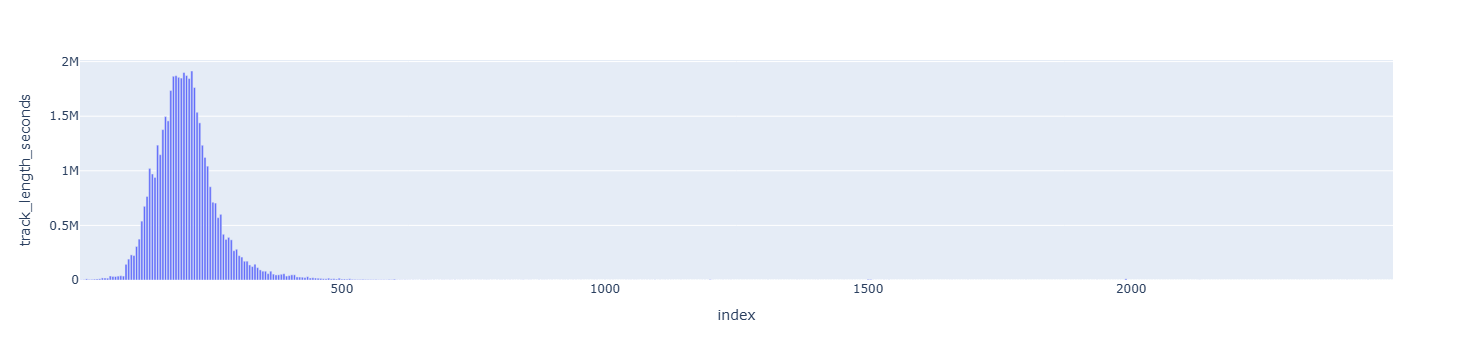

In [31]:
df_listen = data[data["event_type"] == "listen"]

fig = px.bar(
    df_listen["track_length_seconds"].value_counts().reset_index(),
    x="index",
    y="track_length_seconds"
)

fig.show()


Скорее всего это подкасты или склейки. Вероятность прослушивания таких долгих песен сильно ниже и может негативно повлиять на статистику. Поэтому такие песни удаляются из работы. Но такое будем применять только для обучающей выборки 

## Процент прослушивания  (колонка played_ratio_pct)

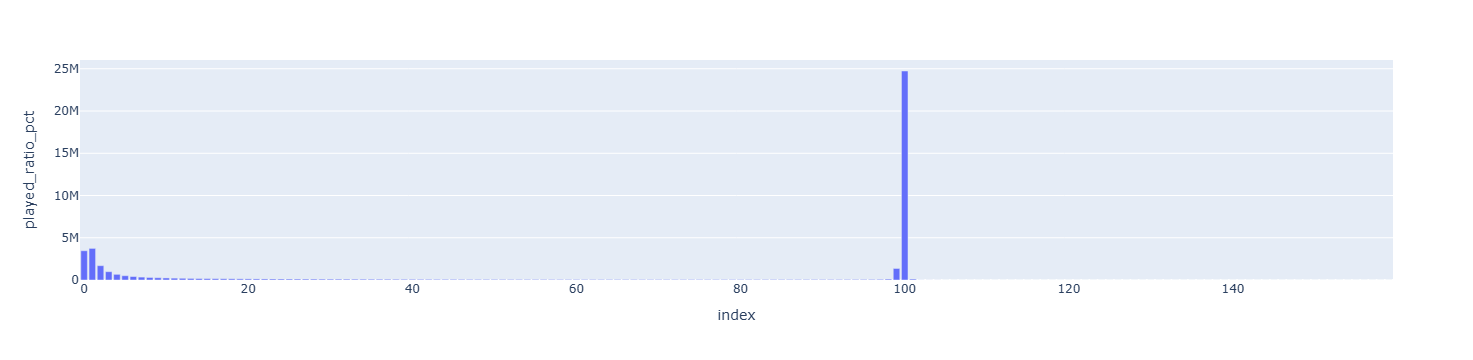

In [32]:
fig = px.bar(
    df_listen["played_ratio_pct"].value_counts().reset_index(),
    x="index",
    y="played_ratio_pct"
)

fig.show()

В столбце played_ratio_pct обнаружены значения, превышающие 100 %, авторы уточнили что это события, когда песня прослушивалась повторно. 

Крайне малые значения played_ratio_pct встречаются тогда, когда пользователь быстро перелистывает трек, и факт прослушивания фиксируется лишь на долю секунды. Такие случаи являются валидными, поэтому ставляем их в датасете.

## Колонка is_organic

В рекомендациях встречаются уже прослушанные пользователем пенси, ниже на графике отображено через сколько дней начинают появляться прослушанные песни в рекомендациях. Наибольшее количество сосредоточено на 2-3 дня. В дальнейшнем именно такой промежуток будет использовать при фильтрации "недавно прослушанные"

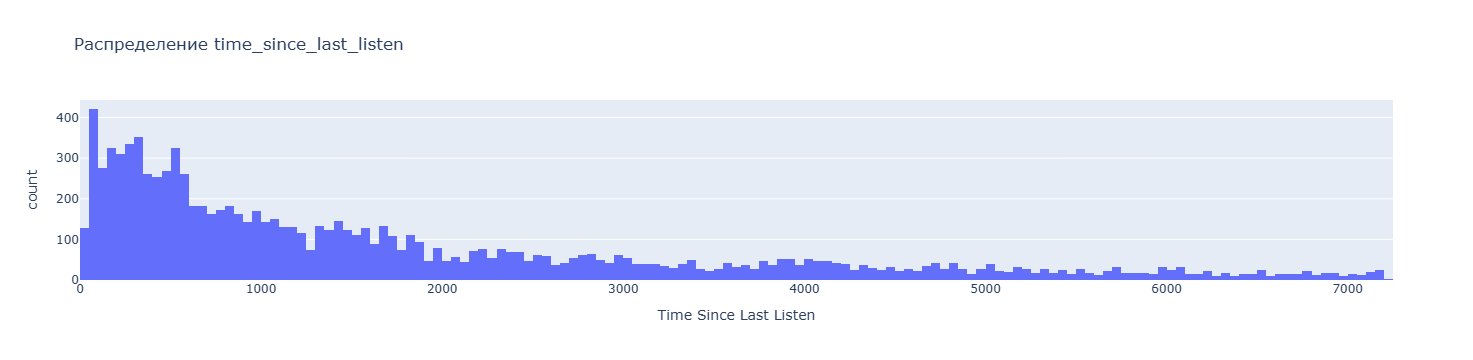

In [37]:
import polars as pl

train = pl.scan_parquet("../data/train_df_preprocessed.parquet").filter(pl.col("is_organic") == 1)
test  = pl.scan_parquet("../data/test_df_preprocessed.parquet").filter(pl.col("is_organic") == 0)

last_train = (
    train
    .group_by(["uid", "item_id"])
    .agg(pl.col("timestamp").max().alias("last_train_ts"))
)

first_test = (
    test
    .group_by(["uid", "item_id"])
    .agg(pl.col("timestamp").min().alias("first_test_ts"))
)

diff = (
    first_test
    .join(last_train, on=["uid", "item_id"], how="left")
    .with_columns(
        (pl.col("first_test_ts") - pl.col("last_train_ts"))
        .alias("time_since_last_listen")
    )
)

tmp = diff.collect().to_pandas()
    
tmp["time_since_last_listen"] = tmp["time_since_last_listen"]/60/60

fig = px.histogram(
    tmp,
    x="time_since_last_listen",
    title="Распределение time_since_last_listen",
    labels={"time_since_last_listen": "Time Since Last Listen"}
)

fig.show()


## Распределение песен и пользователей

### Item id

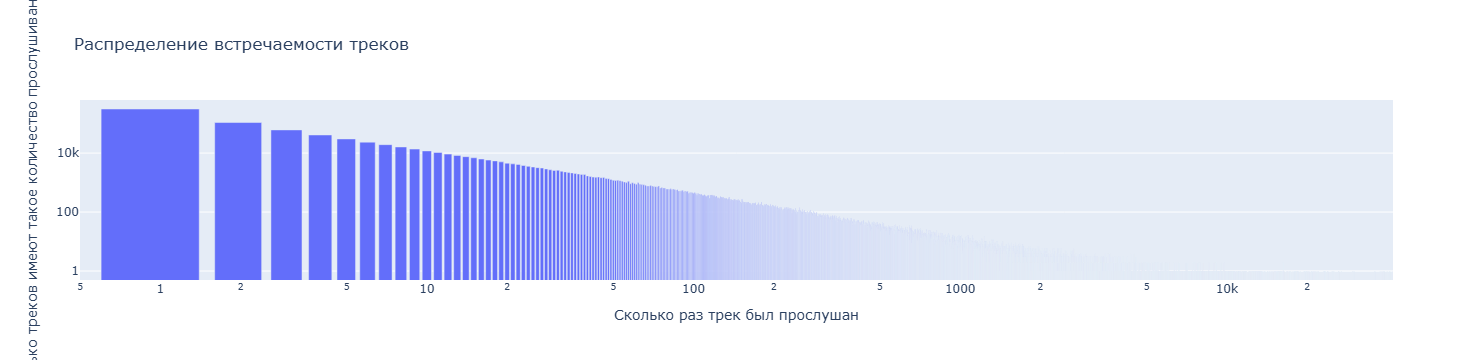

In [34]:
df_listen = data[data["event_type"] == "listen"]
counts = df_listen["item_id"].value_counts()

# сколько треков встречались N раз
freq_of_freq = counts.value_counts().sort_index()
fig = px.bar(
    x=freq_of_freq.index,   # N раз
    y=freq_of_freq.values,  # сколько треков
    labels={
        "x": "Сколько раз трек был прослушан",
        "y": "Сколько треков имеют такое количество прослушиваний"
    },
    title="Распределение встречаемости треков"
)

fig.update_yaxes(type="log")
fig.update_xaxes(type="log") 

fig.show()

В данных встречаются треки, которые были прослушаны всего один–два раза. Такие записи могут вносить шум и искажать распределение, поэтому их желательно исключить из обучающей выборки. При этом важно не удалять их из тестового набора, чтобы не нарушать корректность финальной оценки модели.

Также из обучающей выборки следует убрать треки, которых нет в системе (например, отсутствуют embedding или метаданные). Эти случаи стоит фиксировать отдельно и при необходимости рассчитывать по ним дополнительную метрику.

### User id

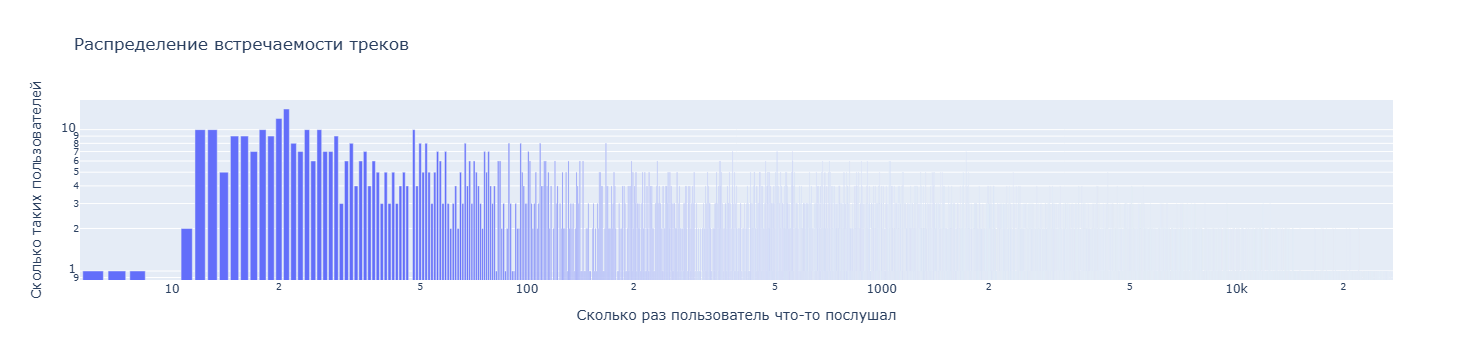

In [29]:
counts = df_listen["uid"].value_counts()

# сколько треков встречались N раз
freq_of_freq = counts.value_counts().sort_index()
freq_of_freq = freq_of_freq[freq_of_freq.index <= 50]

fig = px.bar(
    x=freq_of_freq.index,   # N раз
    y=freq_of_freq.values,  # сколько треков
    labels={
        "x": "Сколько раз пользователь что-то послушал",
        "y": "Сколько таких пользователей"
    },
    title="Распределение встречаемости треков"
)

fig.update_yaxes(type="log")
fig.update_xaxes(type="log") 

fig.show()

Аналогично трекам, из обучающей выборки стоит исключить пользователей с очень малым числом прослушиваний — по ним невозможно построить устойчивые предпочтения, и такие данные могут ухудшать качество модели. Однако удалять таких пользователей из тестовой выборки нельзя: это реальная ситуация, и система должна уметь работать даже с новыми или малозаметными пользователями, для которых данных практически нет.

## Embeddings

Проверим нет ли дубликатов embeddings

In [38]:
embed_df = pl.scan_parquet("../data/source/filtered_embeddings.parquet")

dupes = (
    embed_df
    .with_columns(pl.col("embed").hash().alias("h"))
    .group_by("h")
    .agg([
        pl.len().alias("dup_count"),
        pl.col("item_id").alias("item_ids"),   
    ])
    .filter(pl.col("dup_count") > 1)
    .collect(engine="streaming") 
)

dupes

h,dup_count,item_ids
u64,u32,list[u32]
5743147149241003317,2,"[2406826, 6464727]"
1601183262830302806,2,"[4321404, 6563240]"
843937337114631250,2,"[4807259, 6189185]"
14564443007322250735,2,"[7571452, 7893718]"
452830014931796576,2,"[644935, 3070319]"
…,…,…
10607383229772832497,2,"[2031201, 3272247]"
8707565253003890176,2,"[81977, 425850]"
5889339682209056497,2,"[2834540, 5101572]"


In [41]:
per_of_dup = sum(dupes["dup_count"])/ unique_item_ids_50M *100
print(f"Процент дубликатов {round(per_of_dup, 2)}%")

Процент дубликатов 1.71%


В данных присутствуют дубликаты — вероятно, одна и та же песня была загружена под разными item_id. Процент повторов составляет около 1.7%: показатель небольшой, но всё же достаточно значимый, чтобы их исключить.

Чтобы корректно обработать эту ситуацию, создадим JSON-карту соответствий, где для каждой группы дублей будет выбран один “эталонный” item_id. Остальные идентификаторы будут сопоставлены с ним как эквивалентные.

## Вывод 

| Шаг                                             | Где применяется                | Описание                                                                                           |
| ----------------------------------------------- | ------------------------------ | -------------------------------------------------------------------------------------------------- |
| **1. Обработка лайков и дизлайков**             | Train / Test отдельно          | Нормализуем последовательности реакций, оставляем последнюю корректную реакцию пользователя.       |
| **2. Фильтр по длине трека (60–300 сек)**       | Только Train                   | Удаляем слишком короткие и слишком длинные треки, чтобы не искажать обучение.                      |
| ~~3. Удаление played_ratio_pct > 100%~~         | ~~Везде~~                          | ~~Такие значения невозможны — полностью удаляем.~~ В документации авторов - это явление промотка трека                                                     |
| ~~4. Удаление дублей по прослушиванию~~         | ~~Везде~~                          | ~~Из-за округлённого timestamp встречаются повторяющиеся строки — оставляем только самую последнюю.~~ |
| **5. Удаление одинаковых событий пользователя в один timestamp**         | Train          | Возможная аномалия, удаляем дубликаты                       |
| **6. Удаление редких треков**                   | Только Train                   | Треки с очень малым числом прослушиваний убираются как шумовые.                                    |
| **7. Удаление треков, отсутствующих в системе** | Только Train (Test — оставить) | Из Train удаляем треки без embedding и метаданных; считаем метрику отдельно с ними и без них.      |
| **8. Удаление “редких” пользователей**          | Только Train                   | Пользователи с малым числом событий ухудшают обучение модели.                                      |
| **8. Mapping одинаковых песен по embeddings**          | Везде                   | Один и тот же трек может быть записан несколько раз под разными item_id                                      |